
### Contexto

O trabalho consiste em realizar o treinamento de redes neurais convolucionais na base de dados [Chest X-ray Image (COVID19, PNEUMONIA, and NORMAL) disponível no kaggle](https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image). Esta base de dados contém exames de raio-x de pacientes saudáveis, com pneumonia e com covid19. O objetivo do trabalho é treinar uma rede neural capaz de identificar se o raio-x pertence a uma pessoa saudável ou com uma das duas doenças.



In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision.transforms import v2
import torch
import kagglehub
import os

In [ ]:
# Verificar se CUDA (GPU) está disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda:0


Vamos manter o uso da CUDA aqui, por isso se faz necessário placa de vídeo para execução do treinamento no tempo que fizemos esse teste.

### Download do dataset

In [ ]:
ds_path = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")
root_dir = ds_path + os.listdir(ds_path)[0]

In [ ]:
data_dir = os.path.join(ds_path, os.listdir(ds_path)[0])
data_dir

'/kaggle/input/chest-x-ray-image/Data'

In [ ]:
os.listdir(data_dir)

['test', 'train']

### Definição de parâmetros

In [ ]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Definir o tamanho das imagens (usado para redimensionar)
img_size = (224, 224) # Tamanho padrão para MobileNet

# Hiperparâmetros
batch_size = 32
learning_rate = 0.001
num_epochs = 10
validation_split = 0.2  # Proporção dos dados de treino para validação

### Carregamento de imagem

In [ ]:
def load_img(path):
    # Le a imagem em diversos formatos e garante que a imagem tenha 3 canais
    img = Image.open(path).convert('RGB')
    return img

class LoadAndTransform(object):
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, img):  # Recebe um objeto PIL Image
        # img = v2.functional.to_image(img)
        # img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True)
        transform = transforms.Compose([
            transforms.Resize(self.img_size, antialias=True),
            transforms.ToTensor(), # Move ToTensor para cá
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)

Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']


### Data Augmentation & Loader

In [ ]:

# Data augmentation e normalização para o conjunto de treino
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Aumenta a variedade
    transforms.RandomRotation(degrees=15),
    LoadAndTransform(img_size) # Aplica a transformação customizada
])

# Transformações para validação e teste (apenas redimensionar, converter e normalizar)
val_test_transforms = transforms.Compose([
    LoadAndTransform(img_size) # Aplica a transformação customizada
])

# Criar o dataset completo de treino
full_train_dataset = datasets.ImageFolder(train_dir)

# Calcular os tamanhos dos conjuntos de treino e validação
num_val = int(validation_split * len(full_train_dataset))
num_train = len(full_train_dataset) - num_val

# Dividir o dataset de treino em treino e validação
train_dataset, val_dataset = random_split(full_train_dataset, [num_train, num_val])

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda batch: (torch.stack([train_transforms(x[0]) for x in batch]),
                                                   torch.tensor([x[1] for x in batch])))

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=lambda batch: (torch.stack([val_test_transforms(x[0]) for x in batch]),
                                                  torch.tensor([x[1] for x in batch])))

test_dataset = datasets.ImageFolder(test_dir)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=lambda batch: (torch.stack([val_test_transforms(x[0]) for x in batch]),
                                                  torch.tensor([x[1] for x in batch])))
# Informações sobre as classes
class_names = full_train_dataset.classes
print("Classes:", class_names)

### Custom CNN (Pessoal)

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size[0]//8) * (img_size[1]//8), 512), # Ajustar o tamanho da entrada
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Reutilização de modelos pre-treinados em function

Usei mobilenet pela perfomance, queria algo mais ágil para o treinamento em Colab

In [ ]:
def create_pretrained_model(model_name="mobilenet_v2", num_classes=3, freeze=True):
    if model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
    elif model_name == "mobilenet_v3_small":
        model = models.mobilenet_v3_small(pretrained=True)
    elif model_name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=True)
    else:
        raise ValueError("Modelo não suportado. Escolha 'mobilenet_v2', 'mobilenet_v3_small' ou 'mobilenet_v3_large'.")

    # Congelar os parâmetros
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

    # Modificar o classificador
    if model_name == "mobilenet_v2":
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    else:  # MobileNetV3
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

    return model

### Função de treino

Ela itera por um número especificado de épocas, calculando a perda e a acurácia para cada época nos conjuntos de treinamento e validação. O otimizador é usado para atualizar os pesos do modelo com base no gradiente da perda. A função também rastreia as perdas e acurácias de treinamento e validação ao longo do tempo e as retorna para análise posterior

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device) # Move o modelo para a GPU
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validação
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct_val / total_val
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

## Inicialização da função

In [ ]:


# Inicialização dos modelos
custom_model = CustomCNN(num_classes=len(class_names))
pretrained_frozen_model = create_pretrained_model(model_name="mobilenet_v2", num_classes=len(class_names), freeze=True)
pretrained_finetuned_model = create_pretrained_model(model_name="mobilenet_v2", num_classes=len(class_names), freeze=False)

# Função de perda e otimizadores
criterion = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(custom_model.parameters(), lr=learning_rate)
optimizer_frozen = optim.Adam(pretrained_frozen_model.parameters(), lr=learning_rate)
optimizer_finetuned = optim.Adam(pretrained_finetuned_model.parameters(), lr=learning_rate)

# Treinamento dos modelos
print("Treinando o modelo customizado...")
train_losses_custom, val_losses_custom, train_accuracies_custom, val_accuracies_custom = train_model(custom_model, train_loader, val_loader, criterion, optimizer_custom, num_epochs, device)

print("Treinando o modelo pré-treinado (congelado)...")
train_losses_frozen, val_losses_frozen, train_accuracies_frozen, val_accuracies_frozen = train_model(pretrained_frozen_model, train_loader, val_loader, criterion, optimizer_frozen, num_epochs, device)

print("Treinando o modelo pré-treinado (fine-tuning)...")
train_losses_finetuned, val_losses_finetuned, train_accuracies_finetuned, val_accuracies_finetuned = train_model(pretrained_finetuned_model, train_loader, val_loader, criterion, optimizer_finetuned, num_epochs, device)

Treinando o modelo customizado...
Epoch 1/10, Train Loss: 0.5461, Train Acc: 81.37%, Val Loss: 0.2700, Val Acc: 90.18%
Epoch 2/10, Train Loss: 0.2602, Train Acc: 90.40%, Val Loss: 0.2280, Val Acc: 91.34%
Epoch 3/10, Train Loss: 0.2263, Train Acc: 92.01%, Val Loss: 0.1944, Val Acc: 92.61%
Epoch 4/10, Train Loss: 0.2100, Train Acc: 93.17%, Val Loss: 0.2316, Val Acc: 92.41%
Epoch 5/10, Train Loss: 0.1832, Train Acc: 93.61%, Val Loss: 0.1687, Val Acc: 93.48%
Epoch 6/10, Train Loss: 0.1718, Train Acc: 94.07%, Val Loss: 0.1539, Val Acc: 93.19%
Epoch 7/10, Train Loss: 0.1739, Train Acc: 93.80%, Val Loss: 0.1411, Val Acc: 94.36%
Epoch 8/10, Train Loss: 0.1576, Train Acc: 94.46%, Val Loss: 0.1567, Val Acc: 93.39%
Epoch 9/10, Train Loss: 0.1387, Train Acc: 95.09%, Val Loss: 0.1451, Val Acc: 94.16%
Epoch 10/10, Train Loss: 0.1328, Train Acc: 95.31%, Val Loss: 0.1587, Val Acc: 94.26%
Treinando o modelo pré-treinado (congelado)...
Epoch 1/10, Train Loss: 0.4127, Train Acc: 84.33%, Val Loss: 0.2711,

## Avaliações gerais

### Modelo Customizado:

Train Accuracy: Aumenta de 81.37% para 95.31%.

Validation Accuracy: Aumenta de 90.18% para 94.26%, com algumas flutuações.

Train Loss: Diminui de 0.5461 para 0.1328.

Validation Loss: Diminui de 0.2700 para 0.1411 na sétima época, mas depois aumenta ligeiramente para 0.1587.

Embora a acurácia de treinamento seja consistentemente maior que a acurácia de validação, a diferença não é extremamente grande e a acurácia de validação continua a melhorar ao longo das épocas. A perda de validação atinge seu ponto mais baixo na sétima época e, em seguida, aumenta ligeiramente. Isso pode indicar um overfitting no final do treinamento, mas não é severo.

### Modelo Pré-Treinado (Congelado):

Train Accuracy: Aumenta de 84.33% para 92.76%.

Validation Accuracy: Aumenta de 90.47% para 93.00%, com pequenas flutuações.

Train Loss: Diminui de 0.4127 para 0.1904.

Validation Loss: Diminui de 0.2711 para 0.1809 na nona época, mas aumenta para 0.1926 na última época.

A acurácia de treinamento e validação estão relativamente próximas, e ambas melhoram ao longo das épocas. A perda de validação também diminui, mas começa a aumentar na última época. Isso sugere que o modelo pode estar começando a overfittar no final do treinamento.

### Modelo Fine Tuning

Train Accuracy: Aumenta de 92.40% para 96.60%, atingindo 97.62% na oitava época.

Validation Accuracy: Aumenta de 95.53% para 97.47% na sexta época, mas depois diminui ligeiramente para 95.33% na décima época.

Train Loss: Diminui de 0.2234 para 0.0906.

Validation Loss: Diminui de 0.1142 para 0.0856 na sexta época, mas depois aumenta para 0.1223 na décima época.

A acurácia de treinamento é maior que a acurácia de validação, e a diferença aumenta ao longo do treinamento. A perda de validação atinge seu ponto mais baixo na sexta época e, em seguida, aumenta significativamente. Isso indica que o modelo está overfittando, especialmente após a sexta época. O aumento na perda de validação e a diminuição na acurácia de validação sugerem que o modelo está começando a memorizar os dados de treinamento em vez de generalizar para novos dados.

Nesse caso, seria interessante para todos os modelos fazer ajustes em data augmentation, regularizações ou incluir mais dados no treino para ver o comportamento novamente do treino e ver se há redução ou exclusão do processo de overfit

### Função de Avaliação do Modelo

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, cm

print("Avaliando o modelo customizado...")
y_true_custom, y_pred_custom, cm_custom = evaluate_model(custom_model, test_loader, device, class_names)

print("Avaliando o modelo pré-treinado (congelado)...")
y_true_frozen, y_pred_frozen, cm_frozen = evaluate_model(pretrained_frozen_model, test_loader, device, class_names)

print("Avaliando o modelo pré-treinado (fine-tuning)...")
y_true_finetuned, y_pred_finetuned, cm_finetuned = evaluate_model(pretrained_finetuned_model, test_loader, device, class_names)

Avaliando o modelo customizado...
              precision    recall  f1-score   support

     COVID19       0.99      0.94      0.96       116
      NORMAL       0.91      0.87      0.89       317
   PNEUMONIA       0.95      0.97      0.96       855

    accuracy                           0.94      1288
   macro avg       0.95      0.93      0.94      1288
weighted avg       0.94      0.94      0.94      1288

Avaliando o modelo pré-treinado (congelado)...
              precision    recall  f1-score   support

     COVID19       0.98      0.96      0.97       116
      NORMAL       0.85      0.89      0.87       317
   PNEUMONIA       0.96      0.94      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.93      0.93      1288
weighted avg       0.93      0.93      0.93      1288

Avaliando o modelo pré-treinado (fine-tuning)...
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       116

### Tabelas em markdown

---

### Modelo Customizado

| Classe     | Precision | Recall | F1-Score | Suporte |
|------------|-----------|--------|----------|---------|
| COVID19    | 0.99      | 0.94   | 0.96     | 116     |
| NORMAL     | 0.91      | 0.87   | 0.89     | 317     |
| PNEUMONIA  | 0.95      | 0.97   | 0.96     | 855     |
| **Acurácia**   |           |        | **0.94**     | 1288    |
| **Média Macro** | 0.95      | 0.93   | 0.94     | 1288    |
| **Média Ponderada** | 0.94      | 0.94   | 0.94     | 1288    |

---

### Modelo Pré-treinado (congelado)

| Classe     | Precision | Recall | F1-Score | Suporte |
|------------|-----------|--------|----------|---------|
| COVID19    | 0.98      | 0.96   | 0.97     | 116     |
| NORMAL     | 0.85      | 0.89   | 0.87     | 317     |
| PNEUMONIA  | 0.96      | 0.94   | 0.95     | 855     |
| **Acurácia**   |           |        | **0.93**     | 1288    |
| **Média Macro** | 0.93      | 0.93   | 0.93     | 1288    |
| **Média Ponderada** | 0.93      | 0.93   | 0.93     | 1288    |

---

### Modelo Pré-treinado (fine-tuning)

| Classe     | Precision | Recall | F1-Score | Suporte |
|------------|-----------|--------|----------|---------|
| COVID19    | 0.99      | 0.99   | 0.99     | 116     |
| NORMAL     | 0.88      | 0.96   | 0.92     | 317     |
| PNEUMONIA  | 0.99      | 0.95   | 0.97     | 855     |
| **Acurácia**   |           |        | **0.96**     | 1288    |
| **Média Macro** | 0.95      | 0.97   | 0.96     | 1288    |
| **Média Ponderada** | 0.96      | 0.96   | 0.96     | 1288    |

---


Alta precisão em COVID-19 (próximo de 99% para Fine-Tuning) significa que, quando o modelo prevê COVID-19, ele quase sempre está certo...

Precisão mais baixa em NORMAL (85-88%) sugere mais falsos positivos para essa classe (classificando erroneamente Pneumonia ou COVID-19 como Normal).

O F1-Score mais alto no modelo Fine-Tuning (0.96) indica o melhor equilíbrio entre Precisão e Revocação.

### Curvas de Loss e acurácia

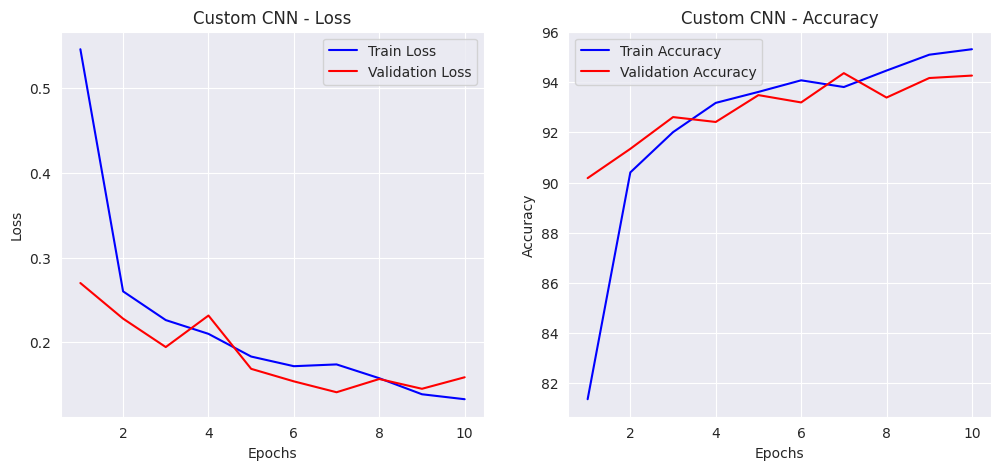

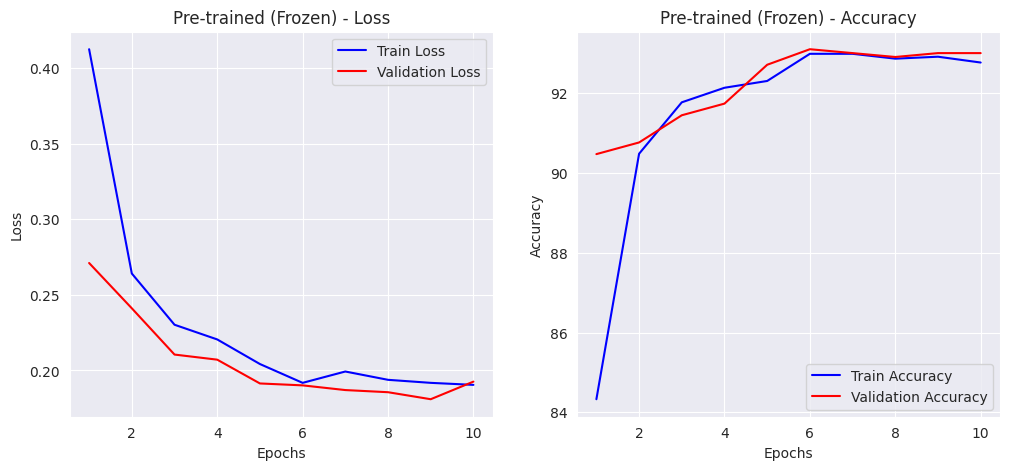

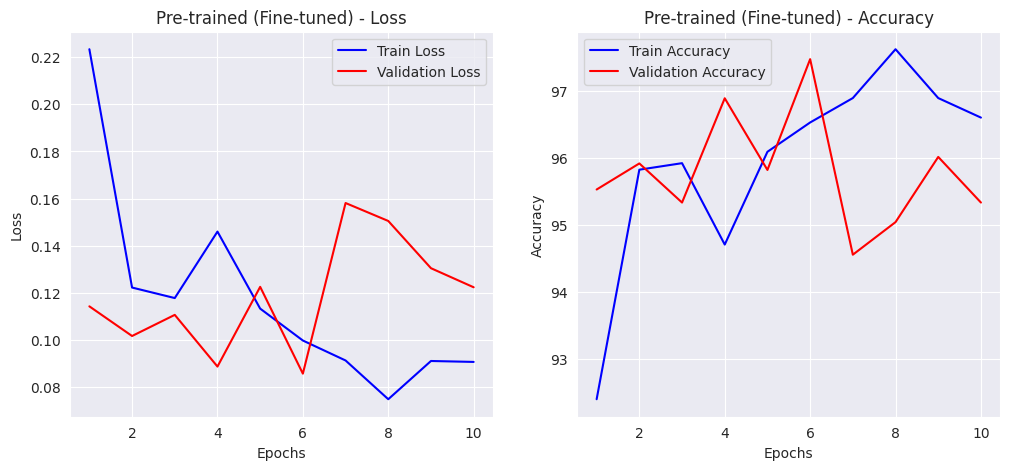

In [ ]:
# Plotar curvas de acurácia e perda
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Train Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_curves(train_losses_custom, val_losses_custom, train_accuracies_custom, val_accuracies_custom, 'Custom CNN')
plot_curves(train_losses_frozen, val_losses_frozen, train_accuracies_frozen, val_accuracies_frozen, 'Pre-trained (Frozen)')
plot_curves(train_losses_finetuned, val_losses_finetuned, train_accuracies_finetuned, val_accuracies_finetuned, 'Pre-trained (Fine-tuned)')


Todos os modelos têm alta acurácia (acima de 93%), indicando bom desempenho geral.
O modelo Fine-Tuning tem a maior acurácia (96%), sugerindo que é o melhor classificador geral.

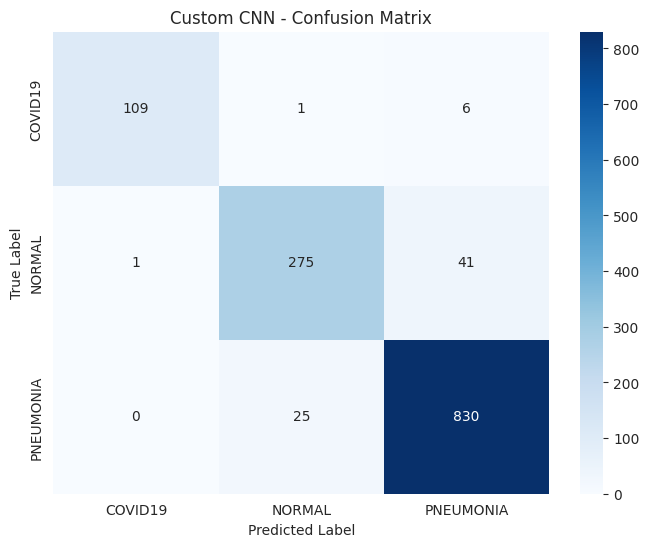

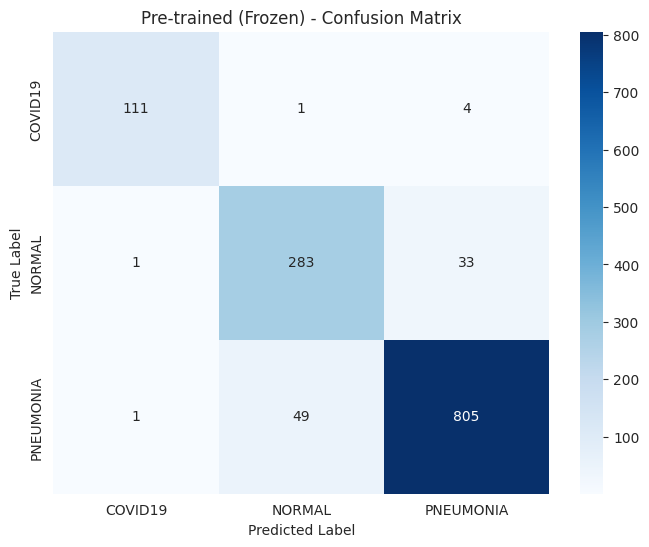

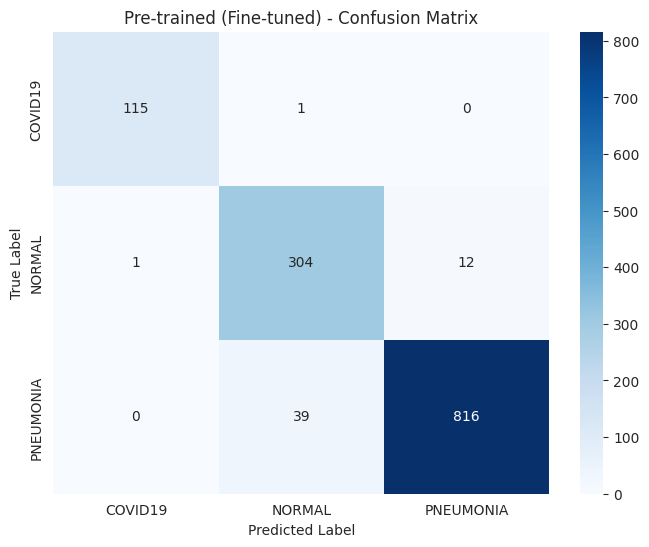

In [ ]:
# Plotar matrizes de confusão
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(cm_custom, class_names, 'Custom CNN')
plot_confusion_matrix(cm_frozen, class_names, 'Pre-trained (Frozen)')
plot_confusion_matrix(cm_finetuned, class_names, 'Pre-trained (Fine-tuned)')

## GradCAM

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image


def load_image(path):
    img = Image.open(path).convert('RGB')
    return img

model_to_analyze = pretrained_finetuned_model
model_to_analyze.eval()
target_layer = model_to_analyze.features[-1] # Última camada convolucional

cam = GradCAM(model=model_to_analyze, target_layers=[target_layer])

In [ ]:
os.listdir(f'{data_dir}/test/PNEUMONIA')[:10]

['PNEUMONIA(3607).jpg',
 'PNEUMONIA(3961).jpg',
 'PNEUMONIA(3958).jpg',
 'PNEUMONIA(3643).jpg',
 'PNEUMONIA(4088).jpg',
 'PNEUMONIA(3679).jpg',
 'PNEUMONIA(3506).jpg',
 'PNEUMONIA(4161).jpg',
 'PNEUMONIA(4121).jpg',
 'PNEUMONIA(3534).jpg']

In [ ]:
os.listdir(f'{data_dir}/test/NORMAL')[:10]

['NORMAL(1312).jpg',
 'NORMAL(1335).jpg',
 'NORMAL(1578).jpg',
 'NORMAL(1358).jpg',
 'NORMAL(1483).jpg',
 'NORMAL(1402).jpg',
 'NORMAL(1539).jpg',
 'NORMAL(1520).jpg',
 'NORMAL(1287).jpg',
 'NORMAL(1454).jpg']

In [ ]:
os.listdir(f'{data_dir}/test/COVID19')[:10]

['COVID19(563).jpg',
 'COVID19(566).jpg',
 'COVID19(531).jpg',
 'COVID19(540).jpg',
 'COVID19(511).jpg',
 'COVID19(538).jpg',
 'COVID19(466).jpg',
 'COVID19(460).jpg',
 'COVID19(489).jpg',
 'COVID19(465).jpg']

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def load_image(image_path):
    """Carrega e converte a imagem para RGB"""
    return Image.open(image_path).convert('RGB')

def get_grad_cam_eval(image_path, source_model):
  pil_img = load_image(image_path)
  model = source_model

  input_transforms = transforms.Compose([
      transforms.Resize((224, 224), antialias=True),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  input_tensor = input_transforms(pil_img).unsqueeze(0).to(device)

  target_layers = [model.features[-1]]  # Última camada das features

  targets = [ClassifierOutputTarget(1)]  # ou None para classe predita
  rgb_img = np.array(pil_img.resize((224, 224))) / 255.0

  with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
      grayscale_cam = grayscale_cam[0, :]
      visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
      model_outputs = cam.outputs

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(rgb_img)
  plt.title('Imagem Original')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(grayscale_cam, cmap='hot')
  plt.title('Mapa de Ativação (GradCAM++)')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(visualization)
  plt.title('Sobreposição GradCAM++')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


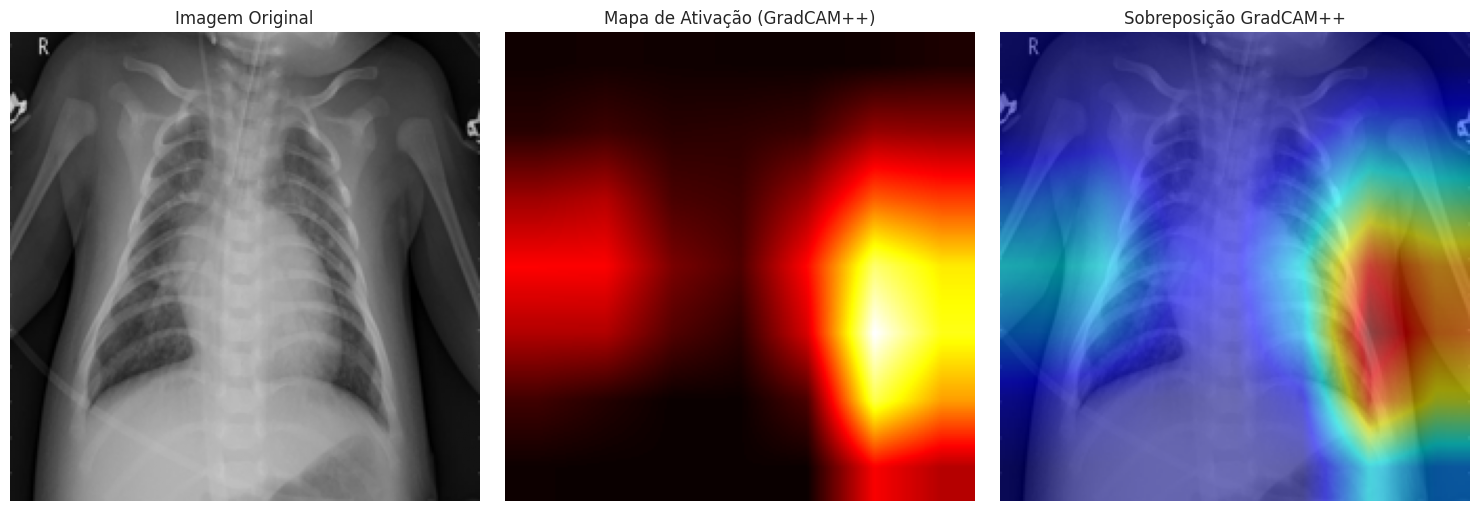

In [ ]:
get_grad_cam_eval(f'{data_dir}/test/PNEUMONIA/PNEUMONIA(3575).jpg', pretrained_finetuned_model)


O mapa destaca uma região com grande intensidade no pulmão inferior direito.

Pneumonias bacterianas costumam apresentar consolidações localizadas, que são altamente visíveis na radiografia. A ativação concentrada nesta área sugere que o modelo identificou corretamente essa alteração radiológica.

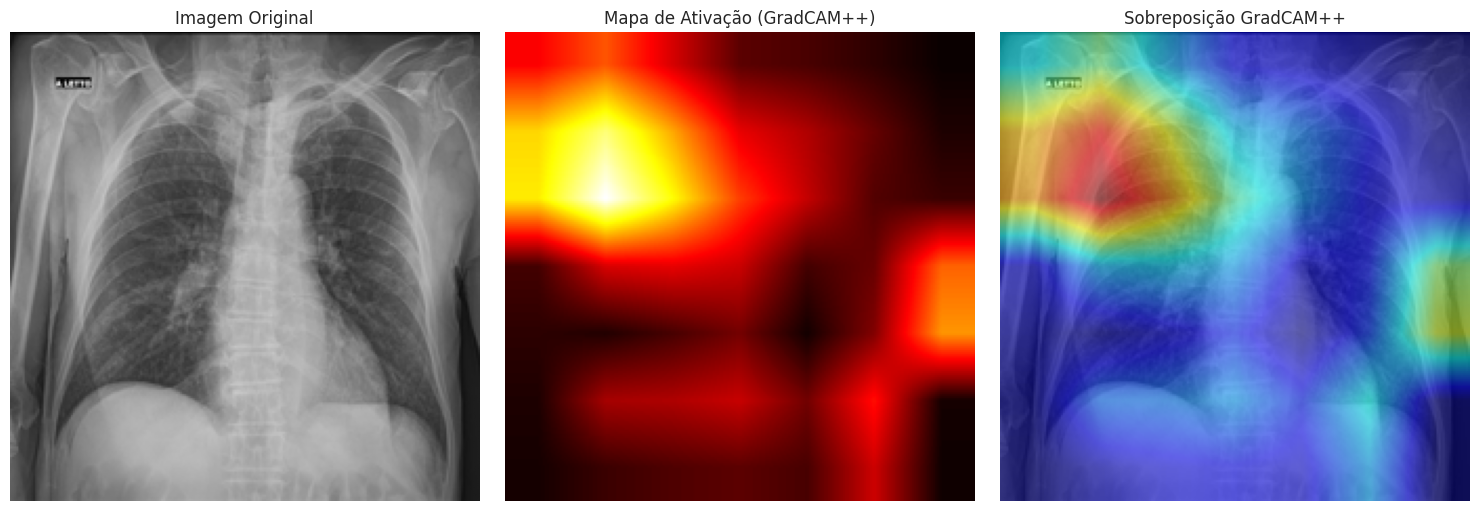

In [ ]:
get_grad_cam_eval(f'{data_dir}/test/COVID19/COVID19(563).jpg', pretrained_finetuned_model)


A COVID-19, especialmente em sua forma viral atípica, costuma afetar áreas periféricas dos pulmões (com padrão em vidro fosco), e a ativação compatível com essas regiões indica que o modelo pode estar sensível a esses padrões.

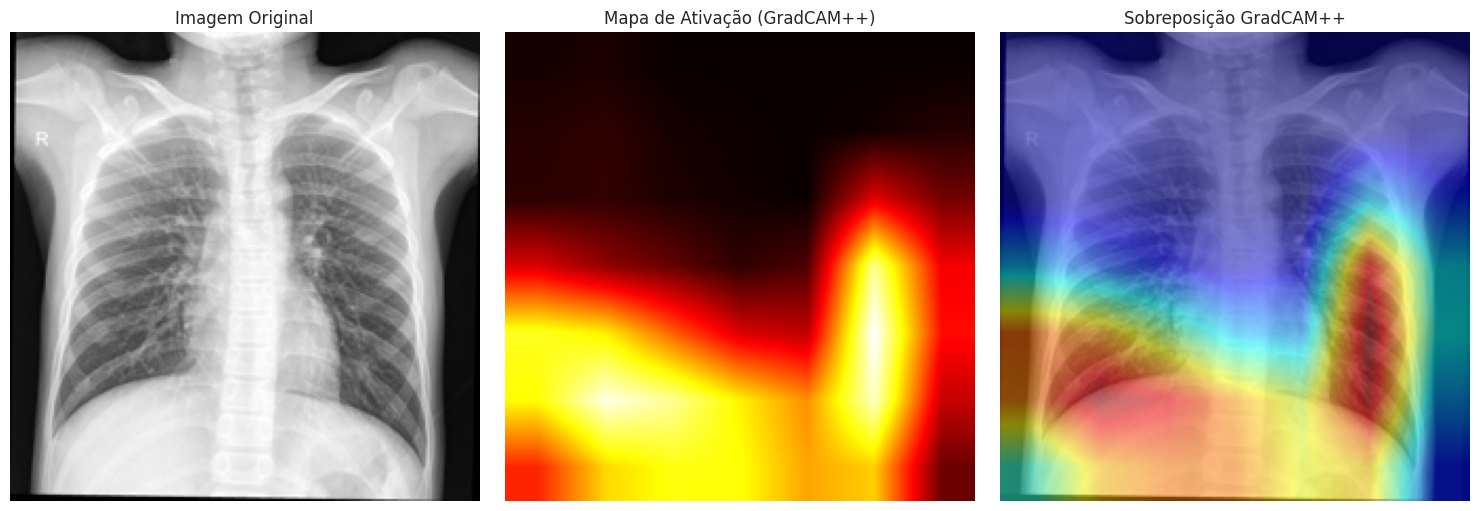

In [ ]:
get_grad_cam_eval(f'{data_dir}/test/NORMAL/NORMAL(1312).jpg', pretrained_finetuned_model)


O mapa de ativação mostra calor mais baixo (tons escuros), especialmente nas regiões periféricas dos pulmões.

Entendo que Oo modelo não encontrou regiões anômalas relevantes; isso é esperado para um caso normal — a rede não foca intensamente em nenhuma área específica, refletindo ausência de alterações patológicas.

O modelo parece estar aprendendo padrões coerentes com a semiologia radiológica esperada para cada condição. Seria interessante medirmos também IoU (intersection over union) entre o mapa de ativação e as máscaras de regiões comprometidas feitas por especialistas.